This project involves looking at a variety of clustering methods and visualizes the results at the end.

**Dataset:** (for the first three dataset, should not use the last column when you run clustering algorithms)
1. Aggregation: url="https://raw.githubusercontent.com/liaochunyang/PIC16/main/PIC16B/05_Clustering/Aggregation.txt"
2. jain: url="https://raw.githubusercontent.com/liaochunyang/PIC16/main/PIC16B/05_Clustering/jain.txt"
3. R15: url="https://raw.githubusercontent.com/liaochunyang/PIC16/main/PIC16B/05_Clustering/R15.txt"
4. circle: url="https://raw.githubusercontent.com/liaochunyang/PIC16/main/PIC16B/05_Clustering/circle.csv"


In [1]:
# your solution here
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from scipy.cluster import hierarchy
import skfuzzy as fuzz
aggregationdata='https://raw.githubusercontent.com/liaochunyang/PIC16/main/PIC16B/05_Clustering/Aggregation.txt'
aggregation = pd.read_table(aggregationdata,encoding='latin-1')
jaindata='https://raw.githubusercontent.com/liaochunyang/PIC16/main/PIC16B/05_Clustering/jain.txt'
jain = pd.read_table(jaindata,encoding='latin-1')
R15data='https://raw.githubusercontent.com/liaochunyang/PIC16/main/PIC16B/05_Clustering/R15.txt'
R15 = pd.read_table(R15data,encoding='latin-1')
circledata='https://raw.githubusercontent.com/liaochunyang/PIC16/main/PIC16B/05_Clustering/circle.csv'
circle=pd.read_csv(circledata,encoding='latin-1')

In [2]:
circle

,x,y
0,-0.058863,0.998266
1,-0.897921,0.440157
2,0.999984,0.005675
3,0.905323,0.424723
4,0.147173,0.989111
...,...,...
145,0.940674,-2.848707
146,-2.153463,2.088683
147,-1.441313,-2.631087
148,-2.952578,0.531302


In [3]:
#function to properly organize data
#returns array of values that can be used for various clustering methods, also excludes last column as per instructions
def organize(df):
    df=df.iloc[:, :-1]
    return df.values

In [4]:
#function for k means clustering
#input is array of values
def kmeansf(input, ax):
    #four clusters because two columns of data, thought 4 would be optimal
    kmeans = KMeans(n_clusters=4)
    #fit data
    kmeans.fit(input)
    #predict data
    y_kmeans = kmeans.predict(input)
    #centers of data
    centers = kmeans.cluster_centers_
    #scatter plot of input data, clusters=predicated data
    ax.scatter(input[:, 0], input[:, 1], c=y_kmeans, s=50, cmap='viridis')
    #add centers data to plot in black
    ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

    


In [5]:
#function for spectral clustering
#input is array of values
def spectralf(input, ax):
    #spectral clustering, chose 10 clusters because it performed best compared to 5 and 7
    spectral = SpectralClustering(n_clusters=10)
    y_spectral = spectral.fit_predict(input)
    ax.scatter(input[:, 0], input[:, 1], c=y_spectral, s=50, cmap='viridis')



For DBSCAN I needed a proper way to find the number of min samples, or epsilon value. I read an article that explained to use KNN to accomplish this: https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
The article explains that for 2d data, the number of min samples should be 4, so I kept that value throughout my calculations. 
For the eps value, at first, I calculated the distances and plotted the values to find the area of maximum curvature, however this is not feasible for many different datasets. Instead, I found a way to find the maximum curvature. I created three functions, one to find the distanes using KNN, one to find the second derivative, and one to find the optimal epsilon value. In the next cell, I apply all three functions in the DBSN function to find the optimal eps value. 

In [6]:
from sklearn.neighbors import NearestNeighbors
#
def distance(input):
    #KNN
    neighbors = NearestNeighbors(n_neighbors=4)
    neighbors_fit = neighbors.fit(input)
    distances, indices = neighbors_fit.kneighbors(input)
    #sorting distances in order
    distances = np.sort(distances, axis=0)
    distances = distances[:, -1]
    return distances

# curvature
def curvature(distances):
    #first derivative
    first_derivative = np.gradient(distances)
    #second derivative
    second_derivative = np.gradient(first_derivative)
    return second_derivative

#optimal epsilon using curvature
def optimaleps(distances):
    #find second deriv of distances
    curve = curvature(distances)
    #index of the max curvature
    max_curvature_index = np.argmax(curve)
    #use the index to find the corresponding epsilon value
    optimal = distances[max_curvature_index]
    return optimal

In [7]:
#function for DBSN clustering
def DBSN(input, ax):
    #read in article that min samples should be 4 for 2d data
    X = input
    #d for distance function
    d = distance(X) 
    #c for curvature function
    c = curvature(d)
    #eps for optimal epsilon
    eps = optimaleps(d)
    #dbscan
    dbscan = DBSCAN(eps=eps, min_samples=4)
    y_dbscan = dbscan.fit_predict(X)
    ax.scatter(X[:, 0], X[:, 1], c=y_dbscan, s=50, cmap='viridis')



In [8]:
#single hierary clustering (min)
def single(input, ax):
    Z = hierarchy.linkage(input, 'single')
    dn = hierarchy.dendrogram(Z, ax=ax)
 

In [9]:
#complete/max func
def complete(input, ax):
    Z = hierarchy.linkage(input, 'complete')
    dn = hierarchy.dendrogram(Z, ax=ax)

In [10]:
#avg 
def avg(input, ax):
    Z = hierarchy.linkage(input, 'average')
    dn = hierarchy.dendrogram(Z, ax=ax)
   

In [11]:
#ward
def ward(input, ax):
    Z = hierarchy.linkage(input, 'ward')
    dn = hierarchy.dendrogram(Z, ax=ax)
    

In [12]:
def fuzzy(input, ax):
    #arbitrary picked three clusters, could test with 4 and 5
    n_clusters = 3
    #fuzzy clustering
    center, MM, initial, d, jm, PC, FPC = fuzz.cluster.cmeans(
    input.T, n_clusters, 2, error=0.005, maxiter=1000, init=None)
    #read markdown for explanation on each parameter
    #center contains the cluster memberships, transpose to get memberships per sample
    #max of membership matrix
    cluster_membership = np.argmax(MM, axis=0)
    #plot input data 
    ax.scatter(input[:, 0], input[:, 1], c=cluster_membership, cmap='viridis', s=20, alpha=0.7)
    #plot center data
    ax.scatter(center[:, 0], center[:, 1], marker='o', c='red', s=100)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

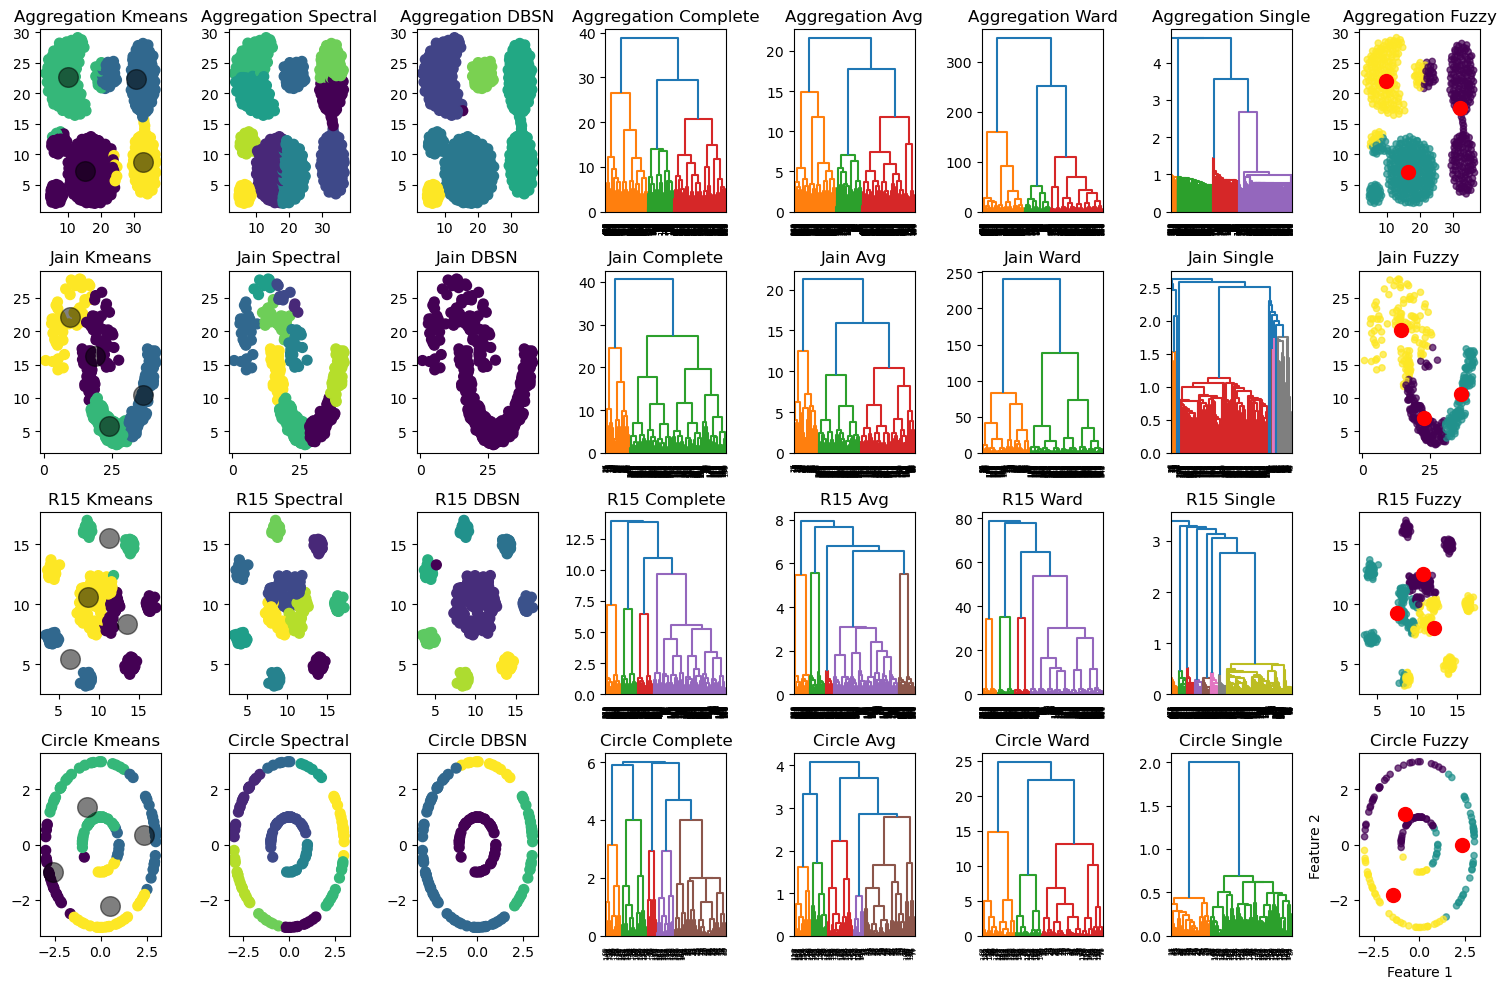

In [13]:
#creating subplot 
fig, axs = plt.subplots(4, 8, figsize=(15, 10))
X=organize(aggregation)
kmeansf(X, axs[0, 0])
axs[0, 0].set_title("Aggregation Kmeans")
spectralf(X,axs[0, 1])
axs[0, 1].set_title("Aggregation Spectral")
DBSN(X, axs[0, 2])
axs[0, 2].set_title("Aggregation DBSN")
complete(X, axs[0, 3])
axs[0, 3].set_title("Aggregation Complete")
avg(X, axs[0, 4])
axs[0, 4].set_title("Aggregation Avg")
ward(X, axs[0, 5])
axs[0, 5].set_title("Aggregation Ward")
single(X, axs[0,6])
axs[0, 6].set_title("Aggregation Single")
fuzzy(X, axs[0,7])
axs[0,7].set_title("Aggregation Fuzzy")
Y=organize(jain)
kmeansf(Y, axs[1, 0])
axs[1, 0].set_title("Jain Kmeans")
spectralf(Y,axs[1, 1])
axs[1, 1].set_title("Jain Spectral")
DBSN(Y, axs[1, 2])
axs[1, 2].set_title("Jain DBSN")
complete(Y, axs[1, 3])
axs[1, 3].set_title("Jain Complete")
avg(Y, axs[1, 4])
axs[1, 4].set_title("Jain Avg")
ward(Y, axs[1, 5])
axs[1, 5].set_title("Jain Ward")
single(Y, axs[1,6])
axs[1, 6].set_title("Jain Single")
fuzzy(Y, axs[1,7])
axs[1,7].set_title("Jain Fuzzy")
Z=organize(R15)
kmeansf(Z, axs[2, 0])
axs[2, 0].set_title("R15 Kmeans")
spectralf(Z,axs[2, 1])
axs[2, 1].set_title("R15 Spectral")
DBSN(Z, axs[2, 2])
axs[2, 2].set_title("R15 DBSN")
complete(Z, axs[2, 3])
axs[2, 3].set_title("R15 Complete")
avg(Z, axs[2, 4])
axs[2, 4].set_title("R15 Avg")
ward(Z, axs[2, 5])
axs[2, 5].set_title("R15 Ward")
single(Z, axs[2,6])
axs[2, 6].set_title("R15 Single")
fuzzy(Z, axs[2,7])
axs[2,7].set_title("R15 Fuzzy")
A=circle.values
kmeansf(A, axs[3, 0])
axs[3, 0].set_title("Circle Kmeans")
spectralf(A,axs[3, 1])
axs[3, 1].set_title("Circle Spectral")
DBSN(A, axs[3, 2])
axs[3, 2].set_title("Circle DBSN")
complete(A, axs[3, 3])
axs[3, 3].set_title("Circle Complete")
avg(A, axs[3, 4])
axs[3, 4].set_title("Circle Avg")
ward(A, axs[3, 5])
axs[3, 5].set_title("Circle Ward")
single(A, axs[3,6])
axs[3, 6].set_title("Circle Single")
fuzzy(A, axs[3,7])
axs[3,7].set_title("Circle Fuzzy")
plt.tight_layout()
plt.show()


I found an article about fuzzy clustering, which is when each data point has partial membership to each cluster. In other clustering methods like k means clustering, each data point is assigned to one specific cluster, but in fuzzy clustering, a data point can be partially assigned to a cluster. The membership values indicate the liklihood to whcih the data point actually belongs to the cluster, and the values for each point across all clusters is equal to 1. 
https://www.analytixlabs.co.in/blog/types-of-clustering-algorithms/#5_Fuzzy_Clustering


Center is a matrix that has all the final clusters, where each row represents a cluster center, and each column is a feature.

MM is a membership matrix where each column represents a data point and each row represents a cluster, and a pair of them represents the degree of membership

Initial is the initial guess for the membership matrix

D is the matrix containing the distances between each data point and each cluster center

JM is a list that has function values at each iteration

PC is the partition coefficient values for each cluster

FPC is the final fuzzy partition coefficient which measures the degree of fuzziness of the resulting clustering